In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 256

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = True

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 61,100,840
Trainable parameters: 61,100,840
Frozen parameters: 0


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [7]:
NUM_EPOCHS = 30
MODEL_NAME = 'alexnet_ft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 42.80s - 
Train Loss: 5.2527, Train Accuracy: 0.0826, Took 35.56s, 
Val Loss: 4.5446, Val Accuracy: 0.1346, Took 7.24s 



Epoch 2/30 Time: 34.80s - 
Train Loss: 4.4476, Train Accuracy: 0.1464, Took 27.95s, 
Val Loss: 4.2744, Val Accuracy: 0.1690, Took 6.85s 



Epoch 3/30 Time: 33.49s - 
Train Loss: 4.1061, Train Accuracy: 0.1843, Took 26.97s, 
Val Loss: 4.0935, Val Accuracy: 0.1953, Took 6.52s 



Epoch 4/30 Time: 34.55s - 
Train Loss: 3.8325, Train Accuracy: 0.2161, Took 28.19s, 
Val Loss: 4.0325, Val Accuracy: 0.2025, Took 6.36s 



Epoch 5/30 Time: 33.97s - 
Train Loss: 3.6264, Train Accuracy: 0.2448, Took 27.60s, 
Val Loss: 3.9835, Val Accuracy: 0.2133, Took 6.37s 



Epoch 6/30 Time: 33.15s - 
Train Loss: 3.3537, Train Accuracy: 0.2854, Took 26.77s, 
Val Loss: 3.9656, Val Accuracy: 0.2178, Took 6.38s 



Epoch 7/30 Time: 34.52s - 
Train Loss: 3.2334, Train Accuracy: 0.3018, Took 27.90s, 
Val Loss: 4.0038, Val Accuracy: 0.2195, Took 6.62s 



Epoch 8/30 Time: 33.05s - 
Train Loss: 3.1249, Train Accuracy: 0.3180, Took 26.59s, 
Val Loss: 3.9614, Val Accuracy: 0.2276, Took 6.46s 



Epoch 9/30 Time: 33.53s - 
Train Loss: 3.0204, Train Accuracy: 0.3347, Took 27.05s, 
Val Loss: 3.9838, Val Accuracy: 0.2262, Took 6.48s 



Epoch 10/30 Time: 33.95s - 
Train Loss: 2.8692, Train Accuracy: 0.3599, Took 27.19s, 
Val Loss: 3.9945, Val Accuracy: 0.2313, Took 6.76s 



Epoch 11/30 Time: 34.58s - 
Train Loss: 2.8242, Train Accuracy: 0.3615, Took 28.10s, 
Val Loss: 4.0026, Val Accuracy: 0.2313, Took 6.48s 



Epoch 12/30 Time: 35.15s - 
Train Loss: 2.7678, Train Accuracy: 0.3758, Took 28.73s, 
Val Loss: 4.0193, Val Accuracy: 0.2313, Took 6.42s 



Epoch 13/30 Time: 33.60s - 
Train Loss: 2.7141, Train Accuracy: 0.3825, Took 27.20s, 
Val Loss: 4.0305, Val Accuracy: 0.2325, Took 6.41s 



Epoch 14/30 Time: 34.11s - 
Train Loss: 2.6305, Train Accuracy: 0.3973, Took 27.71s, 
Val Loss: 4.0447, Val Accuracy: 0.2332, Took 6.40s 



Epoch 15/30 Time: 33.57s - 
Train Loss: 2.6080, Train Accuracy: 0.4043, Took 27.17s, 
Val Loss: 4.0715, Val Accuracy: 0.2347, Took 6.40s 



Epoch 16/30 Time: 32.79s - 
Train Loss: 2.5867, Train Accuracy: 0.4047, Took 26.48s, 
Val Loss: 4.0574, Val Accuracy: 0.2323, Took 6.30s 



Epoch 17/30 Time: 33.17s - 
Train Loss: 2.5527, Train Accuracy: 0.4109, Took 26.81s, 
Val Loss: 4.0649, Val Accuracy: 0.2347, Took 6.35s 



Epoch 18/30 Time: 33.25s - 
Train Loss: 2.5117, Train Accuracy: 0.4163, Took 26.92s, 
Val Loss: 4.0756, Val Accuracy: 0.2355, Took 6.33s 



Epoch 19/30 Time: 34.07s - 
Train Loss: 2.5021, Train Accuracy: 0.4192, Took 27.54s, 
Val Loss: 4.0759, Val Accuracy: 0.2354, Took 6.53s 



Epoch 20/30 Time: 33.85s - 
Train Loss: 2.4875, Train Accuracy: 0.4224, Took 27.31s, 
Val Loss: 4.0802, Val Accuracy: 0.2344, Took 6.54s 



Epoch 21/30 Time: 34.02s - 
Train Loss: 2.4791, Train Accuracy: 0.4218, Took 27.53s, 
Val Loss: 4.0853, Val Accuracy: 0.2361, Took 6.49s 



Epoch 22/30 Time: 32.91s - 
Train Loss: 2.4496, Train Accuracy: 0.4285, Took 26.50s, 
Val Loss: 4.0940, Val Accuracy: 0.2346, Took 6.41s 



Epoch 23/30 Time: 32.93s - 
Train Loss: 2.4482, Train Accuracy: 0.4307, Took 26.63s, 
Val Loss: 4.1000, Val Accuracy: 0.2352, Took 6.30s 



Epoch 24/30 Time: 33.88s - 
Train Loss: 2.4493, Train Accuracy: 0.4298, Took 27.14s, 
Val Loss: 4.0918, Val Accuracy: 0.2358, Took 6.74s 



Epoch 25/30 Time: 33.99s - 
Train Loss: 2.4319, Train Accuracy: 0.4356, Took 27.59s, 
Val Loss: 4.0993, Val Accuracy: 0.2364, Took 6.40s 



Epoch 26/30 Time: 33.87s - 
Train Loss: 2.4351, Train Accuracy: 0.4317, Took 27.25s, 
Val Loss: 4.1016, Val Accuracy: 0.2378, Took 6.62s 



Epoch 27/30 Time: 34.70s - 
Train Loss: 2.4254, Train Accuracy: 0.4339, Took 28.31s, 
Val Loss: 4.1061, Val Accuracy: 0.2360, Took 6.39s 



Epoch 28/30 Time: 34.75s - 
Train Loss: 2.4227, Train Accuracy: 0.4343, Took 28.22s, 
Val Loss: 4.1060, Val Accuracy: 0.2368, Took 6.53s 



Epoch 29/30 Time: 34.38s - 
Train Loss: 2.4225, Train Accuracy: 0.4363, Took 27.94s, 
Val Loss: 4.1044, Val Accuracy: 0.2369, Took 6.44s 



Epoch 30/30 Time: 33.85s - 
Train Loss: 2.4171, Train Accuracy: 0.4339, Took 27.41s, 
Val Loss: 4.1051, Val Accuracy: 0.2369, Took 6.44s 

Training Complete!


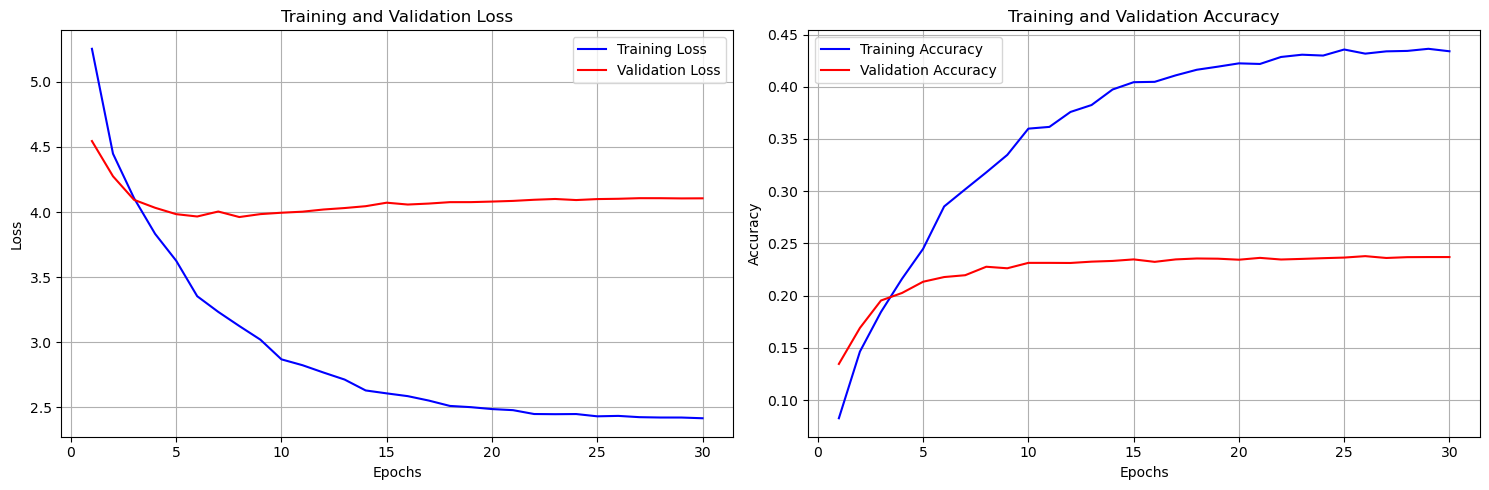

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from alexnet_ft.pth


Best model - Validation Loss: 4.1050, Validation Accuracy: 0.2365


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.2362, Top-5 Accuracy: 0.4576
